# 4. Feature importances and feature selection 

## Outline 

- Interpret the coefficients of linear regression, including for scaled numeric variables. 
- Explain the general concept of feature selection. 
- Discuss and compare different feature selection methods at a high level. 
- Use `sklearn`'s implementation of recursive feature elimination (`RFE`). 
- Implement the forward search algorithm. 
- Relate feature selection to the idea of complexity penalty. 

## Imports

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

<br><br><br><br>

## Data 

In this notebook, we'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/), the dataset we used in notebook 2(regression metric). As usual, to run this notebook you'll need to download the data. Unzip the data into a subdirectory called `data`. For this dataset, train and test have already been separated. We'll be working with the train portion in this lecture. 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv("data/train.csv")
train_df, test_df = train_test_split(df, test_size = 0.10, random_state=123)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
1139,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
558,559,60,RL,57.0,21872,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,175000


- The prediction task is predicting `SalePrice` given features related to properties.  
- Note that the target is numeric, not categorical.

In [3]:
train_df.shape

(1314, 81)

### Let's separate `X` and `y`

In [4]:
X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']

X_test = test_df.drop(columns=['SalePrice'])
y_test = test_df['SalePrice']

### Let's identify feature types

In [5]:
drop_features = ["Id"]
numeric_features = [
    "BedroomAbvGr",
    "KitchenAbvGr", 
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
]

In [6]:
ordinal_features_reg = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
]
ordering = [
    "Po",
    "Fa",
    "TA",
    "Gd",
    "Ex",
]  # if N/A it will just impute something, per below
ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

In [7]:
ordinal_features_oth = [
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
]
ordering_ordinal_oth = [
    ['NA', 'No', 'Mn', 'Av', 'Gd'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],    
    ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
]

In [8]:
categorical_features = list(
    set(X_train.columns)
    - set(numeric_features)
    - set(ordinal_features_reg)
    - set(ordinal_features_oth)    
    - set(drop_features)
)
categorical_features

['MSSubClass',
 'HouseStyle',
 'BldgType',
 'Condition2',
 'Exterior1st',
 'MiscFeature',
 'MasVnrType',
 'MoSold',
 'SaleType',
 'GarageFinish',
 'LotConfig',
 'Utilities',
 'RoofStyle',
 'Alley',
 'CentralAir',
 'LotShape',
 'LandContour',
 'Electrical',
 'Condition1',
 'RoofMatl',
 'Foundation',
 'GarageType',
 'Heating',
 'SaleCondition',
 'LandSlope',
 'Street',
 'PavedDrive',
 'Exterior2nd',
 'Neighborhood',
 'MSZoning']

In [9]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg),
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),    
    (categorical_transformer, categorical_features),
)

In [10]:
preprocessor.fit(X_train)
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                      

In [11]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names(categorical_features)
)
new_columns = numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns

In [12]:
new_columns[10:15]

['BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']

In [13]:
X_train_enc = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=new_columns)
X_train_enc

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
302,0.154795,-0.222647,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
767,1.372763,-0.222647,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
429,0.154795,-0.222647,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1139,0.154795,-0.222647,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
558,0.154795,-0.222647,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,1.372763,-0.222647,-0.025381,-0.127107,-0.054669,2.184405,-0.165485,0.743555,0.843281,-0.090231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1122,0.154795,-0.222647,-0.025381,-0.149788,-1.491366,-2.310284,-0.496757,-1.389065,-0.573129,-0.961498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1346,0.154795,-0.222647,-0.025381,1.168244,0.663680,1.285467,-0.099230,0.888961,-0.573129,-0.314582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1406,-1.063173,-0.222647,0.022331,-0.203265,-0.773017,1.285467,0.033279,1.082835,-0.573129,0.467379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
X_train_enc.shape

(1314, 263)

### Feature correlations

- Let's look at the correlations between various features with other features and the target in our encoded data (first row/column). 
- In simple terms here is how you can interpret correlations between two variables $X$ and $Y$:
  - If $Y$ goes up when $X$ goes up, we say $X$ and $Y$ are positively correlated.
  - If $Y$ goes down when $X$ goes up, we say $X$ and $Y$ are negatively correlated.
  - If $Y$ is unchanged when $X$ changes, we say $X$ and $Y$ are uncorrelated.

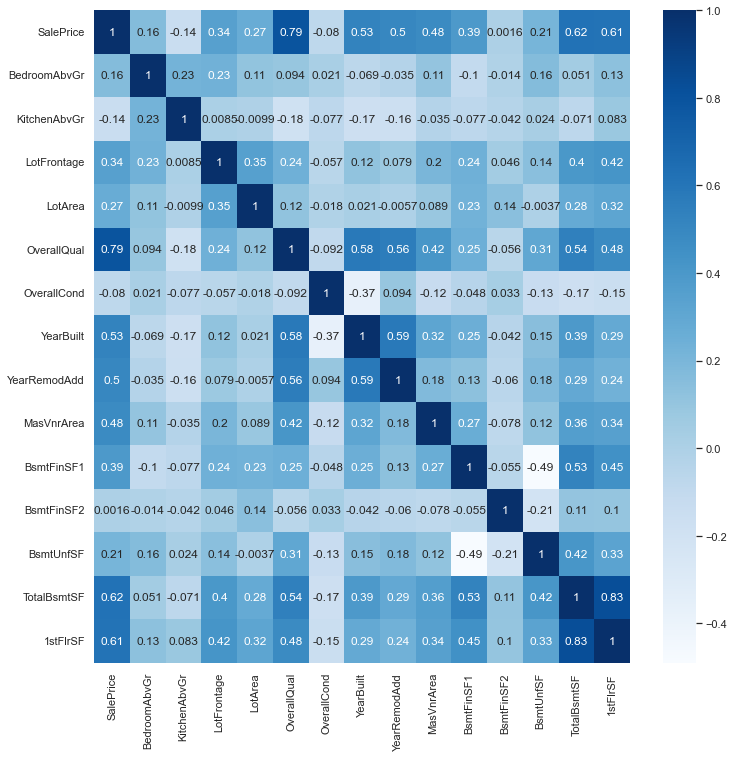

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
cor = pd.concat((y_train, X_train_enc),axis=1).iloc[:,:15].corr();
plt.figure(figsize=(12,12))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- We can immediately see that `SalePrice` is highly correlated with `OverallQual`.
- This is an early hint that `OverallQual` is a useful feature in predicting `SalePrice`.
- However, this approach is **extremely simplistic**.
  - It only looks at each feature in isolation.
  - It only looks at linear associations:
    - What if `SalePrice` is high when `BsmtFullBath` is 2 or 3, but low when it's 0, 1, or 4? They might seem uncorrelated.

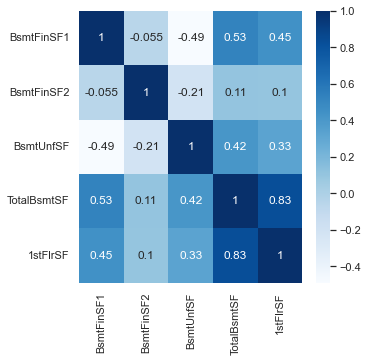

In [16]:
cor = pd.concat((y_train, X_train_enc),axis=1).iloc[:,10:15].corr();
plt.figure(figsize=(5,5))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- Looking at this diagram also tells us the relationship between features. 
  - For example, `1stFlrSF` and `TotalBsmtSF` are highly correlated. 
  - Do we need both of them?
  - If our model says `1stFlrSF` is very important and `TotalBsmtSF` is very unimportant, do we trust those values?
  - Maybe `TotalBsmtSF` only "becomes important" if `1stFlrSF` is removed.
  - Sometimes the opposite happens: a feature only becomes important if another feature is _added_.

<br><br><br><br>

## Feature importances in linear models 

- Like logistic regression, with linear regression we can look at the _coefficients_ for each feature.
- Overall idea: predicted price = intercept + $\sum_i$ coefficient i $\times$ feature i.

In [17]:
from sklearn.linear_model import Ridge
lr = make_pipeline(preprocessor, Ridge())
lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['Id']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
             

Let's look at the coefficients. 

In [18]:
lr_coefs = pd.DataFrame(data=lr[1].coef_, index=new_columns, columns=["Coefficient"])
lr_coefs.head(20)

,Coefficient
BedroomAbvGr,-3723.741570
KitchenAbvGr,-4580.204576
LotFrontage,-1578.664421
LotArea,5109.356718
OverallQual,12487.561839
OverallCond,4855.535334
YearBuilt,4226.684842
YearRemodAdd,324.664715
MasVnrArea,5251.325210
BsmtFinSF1,3667.172851


### Interpreting coefficients of different types of features. 

### Ordinal features

- The ordinal features are easiest to interpret. 

In [19]:
print(ordinal_features_reg)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


In [20]:
lr_coefs.loc["ExterQual", 'Coefficient']

4195.671512467574

- Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by $\sim\$4195$.
  - Wow, that's a lot! 
  - **Remember this is just what the model has learned. It doesn't tell us how the world works**. 

In [21]:
one_example = X_test[:1]

In [22]:
one_example['ExterQual']

147    Gd
Name: ExterQual, dtype: object

Let's perturb the example and change `ExterQual` to `Ex`. 

In [23]:
one_example_perturbed = one_example.copy()
one_example_perturbed["ExterQual"] = 'Ex' # Change Gd to Ex

In [24]:
one_example_perturbed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [25]:
one_example_perturbed['ExterQual']

147    Ex
Name: ExterQual, dtype: object

How does the prediction change after changing `ExterQual` from `Gd` to `Ex`? 

In [26]:
print('Prediction on the original example: ', lr.predict(one_example))
print('Prediction on the perturbed example: ', lr.predict(one_example_perturbed))
print("After changing ExterQual from Gd to Ex increased the prediction by: ", lr.predict(one_example_perturbed) - lr.predict(one_example))

Prediction on the original example:  [224795.63596803]
Prediction on the perturbed example:  [228991.30748049]
After changing ExterQual from Gd to Ex increased the prediction by:  [4195.67151247]


That's exactly the learned coefficient for `ExterQual`! 

In [27]:
lr_coefs.loc["ExterQual", 'Coefficient']

4195.671512467574

So our interpretation is correct! 
- Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by $\sim\$4195$.

### Categorical features

- What about the categorical features?
- We have created a number of columns for each category with OHE and each category gets it's own coefficient. 

In [28]:
print(categorical_features)

['MSSubClass', 'HouseStyle', 'BldgType', 'Condition2', 'Exterior1st', 'MiscFeature', 'MasVnrType', 'MoSold', 'SaleType', 'GarageFinish', 'LotConfig', 'Utilities', 'RoofStyle', 'Alley', 'CentralAir', 'LotShape', 'LandContour', 'Electrical', 'Condition1', 'RoofMatl', 'Foundation', 'GarageType', 'Heating', 'SaleCondition', 'LandSlope', 'Street', 'PavedDrive', 'Exterior2nd', 'Neighborhood', 'MSZoning']


In [29]:
lr_coefs_landslope = lr_coefs[lr_coefs.index.str.startswith("LandSlope")]
lr_coefs_landslope

,Coefficient
LandSlope_Gtl,457.197456
LandSlope_Mod,7420.208381
LandSlope_Sev,-7877.405837


- We can talk about switching from one of these categories to another by picking a "reference" category:

In [30]:
lr_coefs_landslope - lr_coefs_landslope.loc["LandSlope_Gtl"]

,Coefficient
LandSlope_Gtl,0.000000
LandSlope_Mod,6963.010925
LandSlope_Sev,-8334.603292


- If you change the category from `LandSlope_Gtl` to `LandSlope_Mod` the prediction price goes up by $\sim\$6963$
- If you change the category from `LandSlope_Gtl` to `LandSlope_Sev` the prediction price goes down by $\sim\$8334$


Note that this might not make sense in the real world but this is what our model decided to learn given this small amount of data. 

In [31]:
lr_coefs.sort_values(by="Coefficient")

,Coefficient
RoofMatl_ClyTile,-191129.774314
Condition2_PosN,-105552.840565
Heating_OthW,-27260.681308
MSZoning_C (all),-21990.746193
Exterior1st_ImStucc,-19393.964621
...,...
PoolQC,34217.656047
RoofMatl_CompShg,36525.980874
Neighborhood_NridgHt,37532.643270
Neighborhood_StoneBr,39993.978324


- For example, the above coefficient says that "If the roof is made of clay or tile, the predicted price is \\$191K less"?
- Do we believe these interpretations??
  - Do we believe this is how the predictions are being computed? Yes.
  - Do we believe that this is how the world works? No. 

```{note}
If you did `drop='first'` (we didn't) then you already have a reference class, and all the values are with respect to that one. The interpretation depends on whether we did `drop='first'`, hence the hassle.
```

### Interpreting coefficients of numeric features

Let's look at coefficients of `PoolArea` and `LotFrontage`. 

In [32]:
lr_coefs.loc[["PoolArea", "LotArea"]]

,Coefficient
PoolArea,2822.370476
LotArea,5109.356718


Intuition: 

- Tricky because numeric features are **scaled**! 
- **Increasing** `PoolArea` by 1 scaled unit **increases** the predicted price by $\sim\$2822$.
- **Increasing** `LotFrontage` by 1 scaled unit **decreases** the predicted price by $\sim\$1578$.

Does that sound reasonable?

- For `PoolArea`, yes. 
- For `LotFrontage`, that's surprising. Something positive would have made more sense?

It's not the case here but maybe the problem is that `LotFrontage` and `LotArea` are very correlated. `LotArea` has a larger positive coefficient. 

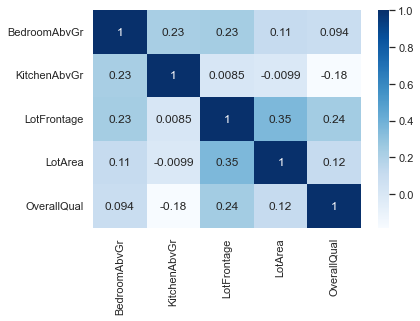

In [33]:
cor = X_train_enc[numeric_features[:5]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

BTW, let's make sure the predictions behave as expected:

In [34]:
one_example = X_test[:1]

In [35]:
one_example

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Let's perturb the example and add 1 to the `LotArea`. 

In [36]:
one_example_perturbed = one_example.copy()
one_example_perturbed["LotArea"] += 1 # add 1 to the LotArea

In [37]:
one_example_perturbed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9506,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Prediction on the original example. 

In [38]:
lr.predict(one_example)

array([224795.63596803])

Prediction on the perturbed example. 

In [39]:
lr.predict(one_example_perturbed)

array([224796.2040233])

- What's the difference between prediction? 
- Does the difference make sense given the coefficient of the feature? 

In [40]:
lr.predict(one_example_perturbed) - lr.predict(one_example)

array([0.56805528])

In [41]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5109.356718


- Why did the prediction only go up by \\$0.57 instead of \\$5109? 
- This is an issue of units. `LotArea` is in sqft, but the coefficient is not $\$5109/\text{sqft}$ **because we scaled the features**. 

### Example showing how can we interpret coefficients of scaled features. 

- The scaler subtracted the mean and divided by the standard deviation.
- The division actually changed the scale! 
- For the unit conversion, we don't care about the subtraction, but only the scaling.

In [42]:
scaler = preprocessor.named_transformers_['pipeline-1']['standardscaler']

In [43]:
import numpy as np
np.sqrt(scaler.var_)

array([8.21039683e-01, 2.18760172e-01, 2.09591390e+01, 8.99447103e+03,
       1.39208177e+00, 1.11242416e+00, 3.01866337e+01, 2.06318985e+01,
       1.77914527e+02, 4.59101890e+02, 1.63890010e+02, 4.42869860e+02,
       4.42817167e+02, 3.92172897e+02, 4.35820743e+02, 4.69800920e+01,
       5.29468070e+02, 5.18276015e-01, 2.33809970e-01, 5.49298599e-01,
       5.02279069e-01, 1.62604030e+00, 6.34398801e-01, 2.40531598e+01,
       7.40269201e-01, 2.10560601e+02, 1.25388753e+02, 6.57325181e+01,
       6.07432962e+01, 3.03088902e+01, 5.38336322e+01, 4.23249944e+01,
       5.22084645e+02, 1.33231649e+00])

In [44]:
lr_scales = pd.DataFrame(data=np.sqrt(scaler.var_), index=numeric_features, columns=["Scale"])
lr_scales.head()

,Scale
BedroomAbvGr,0.821040
KitchenAbvGr,0.218760
LotFrontage,20.959139
LotArea,8994.471032
OverallQual,1.392082


- It seems like `LotArea` was divided by 8994.471032 sqft. 

In [45]:
lr_coefs.loc["LotArea","Coefficient"]

5109.356718094103

In [46]:
lr_coefs.loc["LotArea","Coefficient"]/lr_scales.loc["LotArea","Scale"]

0.5680552752646659

In [47]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5109.356718


- The coefficient tells us that if we increase the **scaled** `LotArea` by one unit the price would go up by $\approx\$5109$. 
- One scaled unit represents $\sim 8994$ sq feet. 

- So if I increase original `LotArea` by one square foot then the predicted price would go up by this amount: 

In [48]:
5109.356718094072/8994.471032 

0.5680552752814816

- This makes much more sense. Now we get the number we got before. 
- That said don't read too much into these coefficients without statistical training. 

### Interim summary

- Correlation among features might make coefficients completely uninterpretable. 
- Fairly straightforward to interpret coefficients of ordinal features. 
- In categorical features, it's often helpful to consider one category as a reference point and think about relative importance. 
- For numeric features, relative importance is meaningful after scaling.
- You have to be careful about the scale of the feature when interpreting the coefficients. 
- Remember that explaining the model $\neq$ explaining the data.  
- the coefficients tell us only about the model and they might not accurately reflect the data. 

## Feature selection: Introduction and motivation 


- With so many ways to add new features, we can increase dimensionality of the data. 
- More features means more complex models, which means increasing the chance of overfitting. 


### What is feature selection?

- Find the features	(columns) $X$ that are important for predicting	$y$, and remove the features that aren't. 

- Given $X = \begin{bmatrix}x_1 & x_2 & \dots & x_n\\  \\  \\  \end{bmatrix}$ and $y = \begin{bmatrix}\\  \\  \\  \end{bmatrix}$, find the columns $1 \leq j \leq n$ in $X$ that are important for predicting $y$.


### Why feature selection? 

- Interpretability: Models are more interpretable with fewer features. If you get the same performance with 10 features instead of 500 features, why not use the model with smaller number of features?     
- Computation: Models fit/predict faster with fewer columns.
- Data collection: What type of new data should I collect? It may be cheaper to collect fewer columns.
- Fundamental tradeoff: Can I reduce overfitting by removing useless features?

Feature selection can often result in better performing (less overfit), easier to understand, and faster model. 


### How do we carry out feature selection? 

- There are a number of ways. 
- You could use domain knowledge to discard features. 
- We are briefly going to look at three automatic feature selection methods from `sklearn`: 
    - Model-based selection 
    - Recursive feature elimination
    - Forward selection 
- Very related to looking at feature importances.

In [49]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
# rng = np.random.RandomState(42)
# noise = rng.normal(size=(len(cancer.data), 50)) # Let's add some random noise in `sklearn`'s breast cancer dataset. 
# X_w_noise = np.hstack([cancer.data, noise])
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0, test_size=0.5
)

In [50]:
X_train.shape

(284, 30)

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

pipe_lr_all_feats = make_pipeline(StandardScaler(), 
                                  LogisticRegression(max_iter=1000))
pipe_lr_all_feats.fit(X_train, y_train)
pd.DataFrame(
    cross_validate(pipe_lr_all_feats, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.013997
score_time     0.001090
test_score     0.968233
train_score    0.987681
dtype: float64

### Model-based selection

- Use a supervised machine learning model to judge the importance of each feature.
- Keep only the most important ones. 
- Supervised machine learning model used for feature selection can be different that the one used as the final estimator. 
- Use a model which has some way to calculate feature importances.

- To use model-based selection, we use `SelectFromModel` transformer.
- It selects features which have the feature importances greater than the provided threshold.
- Below I'm using `RandomForestClassifier` for feature selection with threahold "median" of feature importances. 
- Approximately how many features will be selected? 

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

select_rf = SelectFromModel(
    RandomForestClassifier(n_estimators=100, 
                           random_state=42), 
    threshold="median"
)

We can put the feature selection transformer in a pipeline. 

In [53]:
pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_rf, LogisticRegression(max_iter=1000)
)

pd.DataFrame(
    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.190126
score_time     0.019101
test_score     0.950564
train_score    0.974480
dtype: float64

In [54]:
pipe_lr_model_based.fit(X_train, y_train)
pipe_lr_model_based.named_steps["selectfrommodel"].transform(X_train).shape

(284, 15)

Similar results with only 15 features instead of 30 features. 

### Recursive feature elimination (RFE)

- Build a series of models
- At each iteration, discard the least important feature according to the model. 
- Computationally expensive
- Basic idea
    - fit model
    - find least important feature
    - remove
    - iterate.

### RFE algorithm 

1. Decide $k$, the number of features to select. 
2. Assign importances to features, e.g. by fitting a model and looking at `coef_` or `feature_importances_`.
3. Remove the least important feature.
4. Repeat steps 2-3 until only $k$ features are remaining.

Note that this is **not** the same as just removing all the less important features in one shot!

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [56]:
from sklearn.feature_selection import RFE

# create ranking of features
rfe = RFE(LogisticRegression(), n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)
rfe.ranking_

array([16, 12, 19, 13, 23, 20, 10,  1,  9, 22,  2, 25,  5,  7, 15,  4, 26,
       18, 21,  8,  1,  1,  1,  6, 14, 24,  3,  1, 17, 11])

In [57]:
print(rfe.support_)

[False False False False False False False  True False False False False
 False False False False False False False False  True  True  True False
 False False False  True False False]


In [58]:
print("selected features: ", cancer.feature_names[rfe.support_])

selected features:  ['mean concave points' 'worst radius' 'worst texture' 'worst perimeter'
 'worst concave points']


- How do we know what value to pass to `n_features_to_select`?

- Use `RFECV` which uses cross-validation to select number of features. 

In [59]:
from sklearn.feature_selection import RFECV

rfe_cv = RFECV(LogisticRegression(max_iter=2000), cv=10)
rfe_cv.fit(X_train_scaled, y_train)
print(rfe_cv.support_)
print(cancer.feature_names[rfe_cv.support_])

[False  True False  True False False  True  True  True False  True False
  True  True False  True False False False  True  True  True  True  True
 False False  True  True False  True]
['mean texture' 'mean area' 'mean concavity' 'mean concave points'
 'mean symmetry' 'radius error' 'perimeter error' 'area error'
 'compactness error' 'fractal dimension error' 'worst radius'
 'worst texture' 'worst perimeter' 'worst area' 'worst concavity'
 'worst concave points' 'worst fractal dimension']


In [60]:
rfe_pipe = make_pipeline(
    StandardScaler(),
    RFECV(LogisticRegression(max_iter=2000), cv=10),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

pd.DataFrame(cross_validate(rfe_pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       2.169264
score_time     0.011504
test_score     0.943609
train_score    1.000000
dtype: float64

- Slow because there is cross validation within cross validation 
- Not a big improvement in scores compared to all features on this toy case

<br><br>

### Search and score

- Define a **scoring function** $f(S)$ that measures the quality of the set of features $S$. 
- Now **search** for the set of features $S$ with the best score.

### General idea of search and score methods 

- Example: Suppose you have three features: $A, B, C$
    - Compute **score** for $S = \{\}$
    - Compute **score** for $S = \{A\}$
    - Compute **score** for $S= \{B\}$
    - Compute **score** for $S = \{C\}$
    - Compute **score** for $S = \{A,B\}$    
    - Compute **score** for $S = \{A,C\}$
    - Compute **score** for $S = \{B,C\}$
    - Compute **score** for $S = \{A,B,C\}$    
- Return $S$ with the best score.  
- How many distinct combinations we have to try out? 

### Forward or backward selection 

- Also called wrapper methods
- Shrink or grow feature set by removing or adding one feature at a time 
- Makes the decision based on whether adding/removing the feature improves the CV score or not

<img src='img/forward_selection.png' width="1000" height="1000" />

In [61]:
from sklearn.feature_selection import SequentialFeatureSelector

pipe_forward = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(
        LogisticRegression(max_iter=1000), direction="forward"
    ),
    RandomForestClassifier(n_estimators=100, random_state=42),
)
pd.DataFrame(cross_validate(pipe_forward, X_train, y_train, return_train_score=True)).mean()

fit_time       10.600364
score_time      0.012364
test_score      0.933020
train_score     1.000000
dtype: float64

In [62]:
pipe_forward = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(
        LogisticRegression(max_iter=1000), direction="backward", n_features_to_select=15
    ),
    RandomForestClassifier(n_estimators=100, random_state=42),
)
pd.DataFrame(cross_validate(pipe_forward, X_train, y_train, return_train_score=True)).mean()

fit_time       18.801539
score_time      0.019042
test_score      0.950627
train_score     1.000000
dtype: float64

### Other ways to search 

- Stochastic local search
    - Inject randomness so that we can explore new parts of the search space
    - Simulated annealing
    - Genetic algorithms

### Warnings about feature selection 

- A feature's relevance is only defined in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- If features can be predicted from other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$ for the data you have.

### Problems with feature selection 

- The term 'relevance' is not clearly defined.
- What are things that can go wrong with feature selection?

#### Example: Is "Relevance" clearly defined?

- Consider a supervised classification task of predicting whether someone has particular genetic variation (SNP)

<img src='img/sex_mom_dad.png' width="600" height="600" />

- True model: You almost have the same value as your biological mom.

#### Is "Relevance" clearly defined?

- True model: You almost have the same value for SNP as your biological mom.
    - (SNP = biological mom) with very high probability 
    - (SNP != biological mom) with very low probability 
    

<img src='img/SNP.png' width="400" height="400"/>


#### Is "Relevance" clearly defined?

- What if "mom" feature is repeated?
- Should we pick both? Should we pick one of them because it predicts the other? 
- Dependence, collinearity for linear models
    - If a feature can be predicted from the other, don't know which one to pick. 

<img src='img/sex_mom_mom2_dad.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if we add (maternal) "grandma" feature?
- Is it relevant? 
    - We can predict SNP accurately using this feature
- Conditional independence
    - But grandma is irrelevant given biological mom feature
    - Relevant features may become irrelevant given other features

<img src='img/sex_mom_dad_grandma.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if we do not know biological mom feature and we just have grandma feature
- It becomes relevant now. 
    - Without mom feature this is the best we can do. 
- General problem ("taco Tuesday" problem)
    - Features can become relevant due to missing information 


<img src='img/sex_dad_grandma.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- Are there any relevant features now?
- They may have some common maternal ancestor.   
- What if mom likes dad because they share SNP? 
- General problem (Confounding)
    - Hidden features can make irrelevant features relevant.

<img src='img/sex_dad.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- Now what if we have "sibling" feature? 
- The feature is relevant in predicting SNP but not the cause of SNP. 
- General problem (non causality)
    - the relevant feature may not be causal 

<img src='img/sex_dad_sibling.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if you are given "baby" feature?
- Now the sex feature becomes relevant. 
    - "baby" feature is relevant when sex == F
    
- General problem (context specific relevance)
    - adding a feature can make an irrelevant feature relevant

<img src='img/sex_dad_baby.png' width="600" height="600"/>


#### Warnings about feature selection 

- A feature is only relevant in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- Confounding factors can make irrelevant features the most relevant.
- If features can be predicted from other other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 

- Is feature selection completely hopeless?
    - It is messy but we still need to do it. So we try to do our best! 

#### General advice on finding relevant features

- Try forward selection. 
- Try other feature selection methods (e.g., `RFE`, simulated annealing, genetic algorithms)
- Talk to domain experts; they probably have an idea why certain features are relevant.
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$.

#### Relevant resources 
- [Genome-wide association study](https://en.wikipedia.org/wiki/Genome-wide_association_study)
- [sklearn feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [PyData: A Practical Guide to Dimensionality Reduction Techniques](https://www.youtube.com/watch?v=ioXKxulmwVQ)

#### A rough guide to feature selection (bonus slide)

<img src='img/feature_selection_guidelines.png' width="1000" height="1000" />
